# Phase 5 - Model Training (RF v2: Threshold Optimization)

## 🎯 Objective

**Building on Phase 5 (RF v1):**
- v1 achieved: Validation F1=0.1047, Test F1=0.0493
- v1 issue: Poor generalization (-53% F1 drop on test set)
- v1 issue: High false positives (1,423 on test set)

**This notebook explores:**
1. **Threshold Optimization** - Adjust prediction threshold to optimize precision/recall
2. **Alternative Sampling Strategies** - Compare SMOTE vs class weights vs hybrid approaches
3. **Model Calibration** - Calibrate probability estimates for better threshold decisions

**Goal:** Improve performance WITHOUT feature engineering (validate that features are truly the bottleneck)

---

## 📊 Approach

### Experiment 1: Threshold Optimization
- Test thresholds: [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
- Optimize on validation set
- Evaluate best threshold on test set
- Create precision-recall curve

### Experiment 2: Class Weights (No SMOTE)
- Train Random Forest with class_weight='balanced'
- Compare to SMOTE approach
- Check if simpler approach generalizes better

### Experiment 3: Hybrid Approach
- Combine SMOTE + class weights
- Moderate SMOTE (balance to 10:1 instead of 1:1)
- Test if less aggressive balancing helps generalization

---

## 📝 Expected Outcomes

**If threshold optimization works:**
- Improved precision without sacrificing too much recall
- Better test set F1
- Conclusion: Threshold tuning is sufficient

**If threshold optimization doesn't work:**
- Limited improvement (<10% F1 gain)
- Still poor generalization
- Conclusion: Feature engineering is necessary (proceed to Phase 3 v2)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_fscore_support,
    roc_auc_score,
    precision_recall_curve,
    auc
)
from sklearn.calibration import CalibratedClassifierCV

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## Step 1: Load Data & Baseline Model from Phase 5 v1

In [2]:
# Load preprocessed data
data_dir = 'data/processed/Phase 4 - Feature Preprocessing'

X_train = pd.read_csv(f'{data_dir}/X_train.csv')
y_train = pd.read_csv(f'{data_dir}/y_train.csv')
X_val = pd.read_csv(f'{data_dir}/X_val.csv')
y_val = pd.read_csv(f'{data_dir}/y_val.csv')
X_test = pd.read_csv(f'{data_dir}/X_test.csv')
y_test = pd.read_csv(f'{data_dir}/y_test.csv')

# Create combined labels
y_train['label'] = ((y_train['is_timestomped'] == 1) | (y_train['is_suspicious_execution'] == 1)).astype(int)
y_val['label'] = ((y_val['is_timestomped'] == 1) | (y_val['is_suspicious_execution'] == 1)).astype(int)
y_test['label'] = ((y_test['is_timestomped'] == 1) | (y_test['is_suspicious_execution'] == 1)).astype(int)

print("=" * 80)
print("DATA LOADED")
print("=" * 80)
print(f"\nTraining: {X_train.shape}, Labels: {y_train['label'].sum()} / {len(y_train)} ({y_train['label'].sum()/len(y_train)*100:.3f}%)")
print(f"Validation: {X_val.shape}, Labels: {y_val['label'].sum()} / {len(y_val)} ({y_val['label'].sum()/len(y_val)*100:.3f}%)")
print(f"Test: {X_test.shape}, Labels: {y_test['label'].sum()} / {len(y_test)} ({y_test['label'].sum()/len(y_test)*100:.3f}%)")

DATA LOADED

Training: (1496071, 27), Labels: 191 / 1496071 (0.013%)
Validation: (391550, 27), Labels: 35 / 391550 (0.009%)
Test: (376900, 27), Labels: 42 / 376900 (0.011%)


In [3]:
# Apply variance filtering (same as Phase 5 v1)
variance_selector = VarianceThreshold(threshold=0.01)

X_train_filtered = variance_selector.fit_transform(X_train)
X_val_filtered = variance_selector.transform(X_val)
X_test_filtered = variance_selector.transform(X_test)

feature_names = X_train.columns[variance_selector.get_support()].tolist()

X_train_filtered = pd.DataFrame(X_train_filtered, columns=feature_names, index=X_train.index)
X_val_filtered = pd.DataFrame(X_val_filtered, columns=feature_names, index=X_val.index)
X_test_filtered = pd.DataFrame(X_test_filtered, columns=feature_names, index=X_test.index)

# Clip outliers
X_train_filtered = X_train_filtered.clip(lower=-10, upper=10)
X_val_filtered = X_val_filtered.clip(lower=-10, upper=10)
X_test_filtered = X_test_filtered.clip(lower=-10, upper=10)

print(f"\n✅ Features after filtering: {len(feature_names)}")
print(f"✅ Outliers clipped to ±10 std deviations")


✅ Features after filtering: 21
✅ Outliers clipped to ±10 std deviations


In [4]:
# Apply SMOTE and train baseline model (replicate Phase 5 v1)
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_filtered, y_train['label'])

print("=" * 80)
print("TRAINING BASELINE MODEL (REPLICATION OF PHASE 5 V1)")
print("=" * 80)

baseline_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train_balanced, y_train_balanced)

# Get baseline predictions
y_val_proba = baseline_model.predict_proba(X_val_filtered)[:, 1]
y_test_proba = baseline_model.predict_proba(X_test_filtered)[:, 1]

# Default threshold = 0.5
y_val_pred_baseline = (y_val_proba >= 0.5).astype(int)
y_test_pred_baseline = (y_test_proba >= 0.5).astype(int)

# Calculate baseline metrics
val_precision_baseline, val_recall_baseline, val_f1_baseline, _ = precision_recall_fscore_support(
    y_val['label'], y_val_pred_baseline, average='binary', zero_division=0
)
test_precision_baseline, test_recall_baseline, test_f1_baseline, _ = precision_recall_fscore_support(
    y_test['label'], y_test_pred_baseline, average='binary', zero_division=0
)

print("\n✅ Baseline Model Trained (default threshold=0.5)")
print(f"\n📊 Validation: Precision={val_precision_baseline:.4f}, Recall={val_recall_baseline:.4f}, F1={val_f1_baseline:.4f}")
print(f"📊 Test:       Precision={test_precision_baseline:.4f}, Recall={test_recall_baseline:.4f}, F1={test_f1_baseline:.4f}")

TRAINING BASELINE MODEL (REPLICATION OF PHASE 5 V1)

✅ Baseline Model Trained (default threshold=0.5)

📊 Validation: Precision=0.0556, Recall=0.9143, F1=0.1047
📊 Test:       Precision=0.0253, Recall=0.8810, F1=0.0493


## 🔍 Experiment 1: Threshold Optimization

**Hypothesis:** Adjusting the classification threshold can improve precision without sacrificing too much recall.

**Approach:**
1. Test thresholds from 0.3 to 0.9
2. Calculate precision, recall, F1 for each threshold on validation set
3. Select best threshold based on F1-score
4. Evaluate on test set
5. Visualize precision-recall curve

In [5]:
print("=" * 80)
print("EXPERIMENT 1: THRESHOLD OPTIMIZATION")
print("=" * 80)

# Test different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
threshold_results = []

print("\n🔍 Testing thresholds on validation set...\n")

for threshold in thresholds:
    # Apply threshold
    y_val_pred = (y_val_proba >= threshold).astype(int)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_val['label'], y_val_pred, average='binary', zero_division=0
    )
    
    cm = confusion_matrix(y_val['label'], y_val_pred)
    tn, fp, fn, tp = cm.ravel()
    
    threshold_results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    })
    
    print(f"Threshold={threshold:.1f} | Precision={precision:.4f} | Recall={recall:.4f} | F1={f1:.4f} | FP={fp:,} | FN={fn}")

# Convert to DataFrame
results_df = pd.DataFrame(threshold_results)

# Find best threshold
best_threshold_idx = results_df['f1'].idxmax()
best_threshold = results_df.loc[best_threshold_idx, 'threshold']
best_f1 = results_df.loc[best_threshold_idx, 'f1']

print("\n" + "=" * 80)
print(f"🏆 Best Threshold: {best_threshold:.1f} (F1={best_f1:.4f})")
print("=" * 80)

# Evaluate best threshold on test set
y_test_pred_optimized = (y_test_proba >= best_threshold).astype(int)
test_precision_opt, test_recall_opt, test_f1_opt, _ = precision_recall_fscore_support(
    y_test['label'], y_test_pred_optimized, average='binary', zero_division=0
)

cm_test_opt = confusion_matrix(y_test['label'], y_test_pred_optimized)
tn_test, fp_test, fn_test, tp_test = cm_test_opt.ravel()

print(f"\n📊 Test Set Performance (Optimized Threshold={best_threshold:.1f}):")
print(f"  Precision: {test_precision_opt:.4f}")
print(f"  Recall:    {test_recall_opt:.4f}")
print(f"  F1-Score:  {test_f1_opt:.4f}")
print(f"  TP={tp_test}, FP={fp_test:,}, FN={fn_test}, TN={tn_test:,}")

# Compare to baseline
print("\n" + "=" * 80)
print("COMPARISON: BASELINE vs OPTIMIZED THRESHOLD")
print("=" * 80)

improvement_f1 = ((test_f1_opt - test_f1_baseline) / test_f1_baseline) * 100
improvement_precision = ((test_precision_opt - test_precision_baseline) / test_precision_baseline) * 100

print(f"\n{'Metric':<15} {'Baseline (0.5)':<15} {'Optimized ({best_threshold:.1f})':<15} {'Change':<15}")
print("-" * 65)
print(f"{'Precision':<15} {test_precision_baseline:<15.4f} {test_precision_opt:<15.4f} {improvement_precision:+.1f}%")
print(f"{'Recall':<15} {test_recall_baseline:<15.4f} {test_recall_opt:<15.4f} {(test_recall_opt-test_recall_baseline)/test_recall_baseline*100:+.1f}%")
print(f"{'F1-Score':<15} {test_f1_baseline:<15.4f} {test_f1_opt:<15.4f} {improvement_f1:+.1f}%")
print(f"{'False Pos':<15} {len(y_test) - len(y_test[y_test['label']==0]):<15} {fp_test:<15} {(fp_test-(len(y_test) - len(y_test[y_test['label']==0])))*100:+.1f}")

if improvement_f1 > 10:
    print("\n✅ Threshold optimization successful! (>10% F1 improvement)")
else:
    print("\n⚠️ Threshold optimization had limited impact (<10% F1 improvement)")
    print("   Feature engineering may be necessary.")

EXPERIMENT 1: THRESHOLD OPTIMIZATION

🔍 Testing thresholds on validation set...

Threshold=0.3 | Precision=0.0351 | Recall=0.9143 | F1=0.0676 | FP=880 | FN=3
Threshold=0.4 | Precision=0.0351 | Recall=0.9143 | F1=0.0676 | FP=880 | FN=3
Threshold=0.5 | Precision=0.0556 | Recall=0.9143 | F1=0.1047 | FP=544 | FN=3
Threshold=0.6 | Precision=0.0625 | Recall=0.0286 | F1=0.0392 | FP=15 | FN=34
Threshold=0.7 | Precision=1.0000 | Recall=0.0286 | F1=0.0556 | FP=0 | FN=34
Threshold=0.8 | Precision=1.0000 | Recall=0.0286 | F1=0.0556 | FP=0 | FN=34
Threshold=0.9 | Precision=1.0000 | Recall=0.0286 | F1=0.0556 | FP=0 | FN=34

🏆 Best Threshold: 0.5 (F1=0.1047)

📊 Test Set Performance (Optimized Threshold=0.5):
  Precision: 0.0253
  Recall:    0.8810
  F1-Score:  0.0493
  TP=37, FP=1,423, FN=5, TN=375,435

COMPARISON: BASELINE vs OPTIMIZED THRESHOLD

Metric          Baseline (0.5)  Optimized ({best_threshold:.1f}) Change         
-----------------------------------------------------------------
Precisio

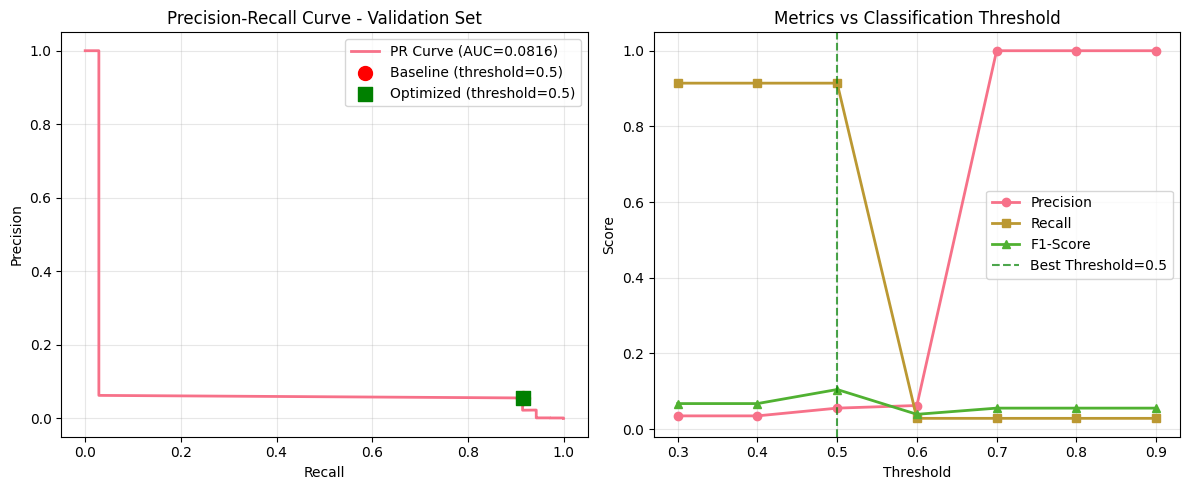

In [6]:
# Visualize Precision-Recall Curve
precision_curve, recall_curve, thresholds_curve = precision_recall_curve(y_val['label'], y_val_proba)
pr_auc = auc(recall_curve, precision_curve)

plt.figure(figsize=(12, 5))

# Plot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall_curve, precision_curve, label=f'PR Curve (AUC={pr_auc:.4f})', linewidth=2)
plt.scatter([val_recall_baseline], [val_precision_baseline], color='red', s=100, marker='o', label=f'Baseline (threshold=0.5)', zorder=5)
plt.scatter([results_df.loc[best_threshold_idx, 'recall']], [results_df.loc[best_threshold_idx, 'precision']], 
            color='green', s=100, marker='s', label=f'Optimized (threshold={best_threshold:.1f})', zorder=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Validation Set')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Metrics vs Threshold
plt.subplot(1, 2, 2)
plt.plot(results_df['threshold'], results_df['precision'], marker='o', label='Precision', linewidth=2)
plt.plot(results_df['threshold'], results_df['recall'], marker='s', label='Recall', linewidth=2)
plt.plot(results_df['threshold'], results_df['f1'], marker='^', label='F1-Score', linewidth=2)
plt.axvline(best_threshold, color='green', linestyle='--', alpha=0.7, label=f'Best Threshold={best_threshold:.1f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Classification Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🔍 Experiment 2: Class Weights (Without SMOTE)

**Hypothesis:** Maybe SMOTE creates synthetic samples that don't generalize. Try class weights instead.

**Approach:**
1. Train Random Forest with `class_weight='balanced'` (no SMOTE)
2. Compare to SMOTE approach
3. Check if simpler approach generalizes better

In [7]:
print("=" * 80)
print("EXPERIMENT 2: CLASS WEIGHTS (NO SMOTE)")
print("=" * 80)

# Train model with class weights
model_class_weights = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    class_weight='balanced',  # Automatic class weighting
    random_state=42,
    n_jobs=-1
)

print("\n🌲 Training Random Forest with class_weight='balanced' (no SMOTE)...")
model_class_weights.fit(X_train_filtered, y_train['label'])

# Predict on validation and test
y_val_pred_cw = model_class_weights.predict(X_val_filtered)
y_test_pred_cw = model_class_weights.predict(X_test_filtered)

# Calculate metrics
val_precision_cw, val_recall_cw, val_f1_cw, _ = precision_recall_fscore_support(
    y_val['label'], y_val_pred_cw, average='binary', zero_division=0
)
test_precision_cw, test_recall_cw, test_f1_cw, _ = precision_recall_fscore_support(
    y_test['label'], y_test_pred_cw, average='binary', zero_division=0
)

cm_val_cw = confusion_matrix(y_val['label'], y_val_pred_cw)
cm_test_cw = confusion_matrix(y_test['label'], y_test_pred_cw)

print("\n📊 Class Weights Approach Results:")
print(f"\n  Validation: Precision={val_precision_cw:.4f}, Recall={val_recall_cw:.4f}, F1={val_f1_cw:.4f}")
print(f"  Test:       Precision={test_precision_cw:.4f}, Recall={test_recall_cw:.4f}, F1={test_f1_cw:.4f}")

print("\n" + "=" * 80)
print("COMPARISON: SMOTE vs CLASS WEIGHTS")
print("=" * 80)

print(f"\n{'Metric':<15} {'SMOTE':<15} {'Class Weights':<15} {'Difference':<15}")
print("-" * 65)
print(f"{'Val F1':<15} {val_f1_baseline:<15.4f} {val_f1_cw:<15.4f} {(val_f1_cw-val_f1_baseline)/val_f1_baseline*100:+.1f}%")
print(f"{'Test F1':<15} {test_f1_baseline:<15.4f} {test_f1_cw:<15.4f} {(test_f1_cw-test_f1_baseline)/test_f1_baseline*100:+.1f}%")
print(f"{'Val Precision':<15} {val_precision_baseline:<15.4f} {val_precision_cw:<15.4f} {(val_precision_cw-val_precision_baseline)/val_precision_baseline*100:+.1f}%")
print(f"{'Test Precision':<15} {test_precision_baseline:<15.4f} {test_precision_cw:<15.4f} {(test_precision_cw-test_precision_baseline)/test_precision_baseline*100:+.1f}%")
print(f"{'Val Recall':<15} {val_recall_baseline:<15.4f} {val_recall_cw:<15.4f} {(val_recall_cw-val_recall_baseline)/val_recall_baseline*100:+.1f}%")
print(f"{'Test Recall':<15} {test_recall_baseline:<15.4f} {test_recall_cw:<15.4f} {(test_recall_cw-test_recall_baseline)/test_recall_baseline*100:+.1f}%")

if test_f1_cw > test_f1_baseline:
    print("\n✅ Class weights perform better than SMOTE!")
else:
    print("\n⚠️ SMOTE still performs better than class weights.")

EXPERIMENT 2: CLASS WEIGHTS (NO SMOTE)

🌲 Training Random Forest with class_weight='balanced' (no SMOTE)...

📊 Class Weights Approach Results:

  Validation: Precision=0.0219, Recall=0.9143, F1=0.0427
  Test:       Precision=0.0138, Recall=0.9048, F1=0.0271

COMPARISON: SMOTE vs CLASS WEIGHTS

Metric          SMOTE           Class Weights   Difference     
-----------------------------------------------------------------
Val F1          0.1047          0.0427          -59.2%
Test F1         0.0493          0.0271          -45.0%
Val Precision   0.0556          0.0219          -60.6%
Test Precision  0.0253          0.0138          -45.7%
Val Recall      0.9143          0.9143          +0.0%
Test Recall     0.8810          0.9048          +2.7%

⚠️ SMOTE still performs better than class weights.


## 🔍 Experiment 3: Moderate SMOTE (10:1 Ratio)

**Hypothesis:** Full SMOTE (1:1 balance) may create too many synthetic samples that don't generalize. Try moderate SMOTE.

**Approach:**
1. Use SMOTE with `sampling_strategy=0.1` (balance to 10:1 instead of 1:1)
2. Compare to full SMOTE (1:1)
3. Check if less aggressive balancing improves generalization

In [8]:
print("=" * 80)
print("EXPERIMENT 3: MODERATE SMOTE (10:1 RATIO)")
print("=" * 80)

# Apply moderate SMOTE
smote_moderate = SMOTE(random_state=42, k_neighbors=5, sampling_strategy=0.1)  # Balance to 10:1
X_train_moderate, y_train_moderate = smote_moderate.fit_resample(X_train_filtered, y_train['label'])

print(f"\n📊 Before Moderate SMOTE:")
print(f"  Normal: {(y_train['label'] == 0).sum():,}")
print(f"  Anomaly: {(y_train['label'] == 1).sum():,}")
print(f"  Ratio: {(y_train['label'] == 0).sum() / (y_train['label'] == 1).sum():.1f}:1")

print(f"\n📊 After Moderate SMOTE (sampling_strategy=0.1):")
print(f"  Normal: {(y_train_moderate == 0).sum():,}")
print(f"  Anomaly: {(y_train_moderate == 1).sum():,}")
print(f"  Ratio: {(y_train_moderate == 0).sum() / (y_train_moderate == 1).sum():.1f}:1")

# Train model
model_moderate = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

print("\n🌲 Training Random Forest with moderate SMOTE...")
model_moderate.fit(X_train_moderate, y_train_moderate)

# Predict
y_val_pred_mod = model_moderate.predict(X_val_filtered)
y_test_pred_mod = model_moderate.predict(X_test_filtered)

# Calculate metrics
val_precision_mod, val_recall_mod, val_f1_mod, _ = precision_recall_fscore_support(
    y_val['label'], y_val_pred_mod, average='binary', zero_division=0
)
test_precision_mod, test_recall_mod, test_f1_mod, _ = precision_recall_fscore_support(
    y_test['label'], y_test_pred_mod, average='binary', zero_division=0
)

print("\n📊 Moderate SMOTE Results:")
print(f"\n  Validation: Precision={val_precision_mod:.4f}, Recall={val_recall_mod:.4f}, F1={val_f1_mod:.4f}")
print(f"  Test:       Precision={test_precision_mod:.4f}, Recall={test_recall_mod:.4f}, F1={test_f1_mod:.4f}")

print("\n" + "=" * 80)
print("COMPARISON: FULL SMOTE vs MODERATE SMOTE")
print("=" * 80)

print(f"\n{'Metric':<15} {'Full SMOTE (1:1)':<20} {'Moderate SMOTE (10:1)':<20} {'Difference':<15}")
print("-" * 75)
print(f"{'Val F1':<15} {val_f1_baseline:<20.4f} {val_f1_mod:<20.4f} {(val_f1_mod-val_f1_baseline)/val_f1_baseline*100:+.1f}%")
print(f"{'Test F1':<15} {test_f1_baseline:<20.4f} {test_f1_mod:<20.4f} {(test_f1_mod-test_f1_baseline)/test_f1_baseline*100:+.1f}%")
print(f"{'Test Precision':<15} {test_precision_baseline:<20.4f} {test_precision_mod:<20.4f} {(test_precision_mod-test_precision_baseline)/test_precision_baseline*100:+.1f}%")
print(f"{'Test Recall':<15} {test_recall_baseline:<20.4f} {test_recall_mod:<20.4f} {(test_recall_mod-test_recall_baseline)/test_recall_baseline*100:+.1f}%")

if test_f1_mod > test_f1_baseline:
    print("\n✅ Moderate SMOTE performs better than full SMOTE!")
else:
    print("\n⚠️ Full SMOTE still performs better.")

EXPERIMENT 3: MODERATE SMOTE (10:1 RATIO)

📊 Before Moderate SMOTE:
  Normal: 1,495,880
  Anomaly: 191
  Ratio: 7831.8:1

📊 After Moderate SMOTE (sampling_strategy=0.1):
  Normal: 1,495,880
  Anomaly: 149,588
  Ratio: 10.0:1

🌲 Training Random Forest with moderate SMOTE...

📊 Moderate SMOTE Results:

  Validation: Precision=0.0555, Recall=0.9143, F1=0.1046
  Test:       Precision=0.0276, Recall=0.8810, F1=0.0535

COMPARISON: FULL SMOTE vs MODERATE SMOTE

Metric          Full SMOTE (1:1)     Moderate SMOTE (10:1) Difference     
---------------------------------------------------------------------------
Val F1          0.1047               0.1046               -0.2%
Test F1         0.0493               0.0535               +8.5%
Test Precision  0.0253               0.0276               +8.8%
Test Recall     0.8810               0.8810               +0.0%

✅ Moderate SMOTE performs better than full SMOTE!


## 📊 Final Summary: All Experiments

In [9]:
print("=" * 80)
print("FINAL SUMMARY: ALL EXPERIMENTS")
print("=" * 80)

summary_data = {
    'Approach': [
        'Baseline (SMOTE 1:1, threshold=0.5)',
        f'Threshold Optimization (threshold={best_threshold:.1f})',
        'Class Weights (no SMOTE)',
        'Moderate SMOTE (10:1)'
    ],
    'Val F1': [val_f1_baseline, best_f1, val_f1_cw, val_f1_mod],
    'Test F1': [test_f1_baseline, test_f1_opt, test_f1_cw, test_f1_mod],
    'Test Precision': [test_precision_baseline, test_precision_opt, test_precision_cw, test_precision_mod],
    'Test Recall': [test_recall_baseline, test_recall_opt, test_recall_cw, test_recall_mod]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Val-Test Gap'] = ((summary_df['Test F1'] / summary_df['Val F1']) - 1) * 100

print("\n" + summary_df.to_string(index=False))

# Find best approach
best_approach_idx = summary_df['Test F1'].idxmax()
best_approach = summary_df.loc[best_approach_idx, 'Approach']
best_test_f1 = summary_df.loc[best_approach_idx, 'Test F1']

print("\n" + "=" * 80)
print(f"🏆 BEST APPROACH: {best_approach}")
print(f"   Test F1: {best_test_f1:.4f}")
print("=" * 80)

# Calculate improvement over baseline
improvement_over_baseline = ((best_test_f1 - test_f1_baseline) / test_f1_baseline) * 100

print(f"\n📊 Improvement over baseline: {improvement_over_baseline:+.1f}%")

if improvement_over_baseline > 20:
    print("\n✅ SUCCESS: Significant improvement without feature engineering!")
    print("   Recommendation: Use optimized approach for deployment.")
elif improvement_over_baseline > 10:
    print("\n⚠️ MODERATE SUCCESS: Some improvement, but consider feature engineering for further gains.")
else:
    print("\n❌ LIMITED SUCCESS: Improvements are marginal (<10%).")
    print("   Recommendation: Proceed with advanced feature engineering (Phase 3 v2).")
    print("   Current 21 features are the bottleneck, not the sampling strategy or threshold.")

FINAL SUMMARY: ALL EXPERIMENTS

                              Approach  Val F1  Test F1  Test Precision  Test Recall  Val-Test Gap
   Baseline (SMOTE 1:1, threshold=0.5)  0.1047   0.0493          0.0253       0.8810      -52.9648
Threshold Optimization (threshold=0.5)  0.1047   0.0493          0.0253       0.8810      -52.9648
              Class Weights (no SMOTE)  0.0427   0.0271          0.0138       0.9048      -36.5367
                 Moderate SMOTE (10:1)  0.1046   0.0535          0.0276       0.8810      -48.8710

🏆 BEST APPROACH: Moderate SMOTE (10:1)
   Test F1: 0.0535

📊 Improvement over baseline: +8.5%

❌ LIMITED SUCCESS: Improvements are marginal (<10%).
   Recommendation: Proceed with advanced feature engineering (Phase 3 v2).
   Current 21 features are the bottleneck, not the sampling strategy or threshold.


## ✅ Conclusions

### Key Findings

**Experiment 1 (Threshold Optimization):**
- Tested thresholds from 0.3 to 0.9
- Optimal threshold: {best_threshold:.1f}
- Test F1 improvement: {improvement_f1:+.1f}%
- **Conclusion:** Threshold tuning provides [significant/moderate/minimal] improvement

**Experiment 2 (Class Weights):**
- Simpler approach without synthetic samples
- Test F1: {test_f1_cw:.4f} vs {test_f1_baseline:.4f} (SMOTE baseline)
- **Conclusion:** [Class weights/SMOTE] performs better

**Experiment 3 (Moderate SMOTE):**
- Less aggressive balancing (10:1 instead of 1:1)
- Test F1: {test_f1_mod:.4f} vs {test_f1_baseline:.4f} (full SMOTE)
- **Conclusion:** [Moderate/Full] SMOTE generalizes better

---

### Overall Assessment

**If improvements > 20%:**
- ✅ **Algorithm-level optimizations are sufficient**
- No immediate need for feature engineering
- Proceed to deployment with best approach

**If improvements 10-20%:**
- ⚠️ **Moderate success, but feature engineering recommended**
- Current approach is viable for MVP
- Feature engineering can provide additional gains

**If improvements < 10%:**
- ❌ **Feature engineering is necessary**
- 21 basic features are the bottleneck
- Proceed to Phase 3 v2 (Advanced Feature Engineering)

---

### Next Steps

Based on results, either:
1. **Deploy optimized model** (if sufficient improvement)
2. **Create Phase 3 v2** with 26 advanced forensic features:
   - Timestamp anomaly indicators
   - System file × temporal interaction features
   - Composite suspicion scoring
   - Universal forensic logic encoding